In [1]:
!pip install ultralytics torch torchvision torchaudio
!pip install opencv-python opencv-python-headless
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 12.5 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO

# Load YOLO v8 model
yolo_model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.5MB/s]


In [4]:
import torch
import torchvision.transforms as T

# Load MiDaS from PyTorch Hub
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")  # Using MiDaS_small for lighter computation; you can try 'MiDaS' for a larger model
midas.eval()  # Set model to evaluation mode

# Set up the transformations
midas_transform = T.Compose([
    T.Resize((384, 384)),  # Resize input to match MiDaS model requirements
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas = midas.to(device)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt
100%|██████████| 81.8M/81.8M [00:00<00:00, 116MB/s]



0: 448x640 3 persons, 1 tie, 1 cell phone, 218.5ms
Speed: 6.7ms preprocess, 218.5ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


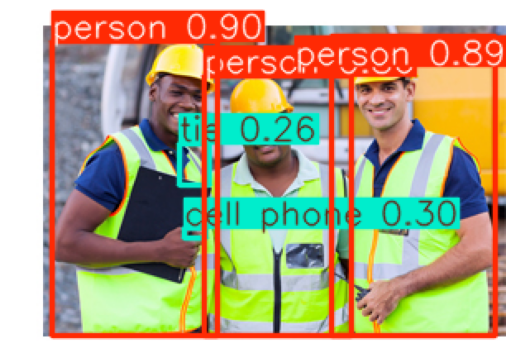

Bounding Boxes: [[25.14504623413086, 19.21773338317871, 125.93672943115234, 197.48297119140625], [194.66189575195312, 16.91034698486328, 293.8701171875, 197.80093383789062], [117.77074432373047, 40.046478271484375, 206.5758819580078, 197.31724548339844], [105.22209930419922, 132.68710327148438, 118.60930633544922, 138.1896514892578], [102.2111587524414, 81.82563781738281, 120.43279266357422, 106.99342346191406]]


In [12]:
import cv2
import matplotlib.pyplot as plt

# Load a sample image
image_path = "/content/midasyolotest2.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform object detection with YOLO
results = yolo_model(image_rgb)

# Plot the detected bounding boxes
plt.imshow(results[0].plot())  # Display the first result with bounding boxes
plt.axis("off")
plt.show()

# Extract bounding box coordinates
bounding_boxes = []
for result in results:
    for box in result.boxes.xyxy:
        x_min, y_min, x_max, y_max = box[:4]
        bounding_boxes.append([x_min.item(), y_min.item(), x_max.item(), y_max.item()])

print("Bounding Boxes:", bounding_boxes)

In [13]:
from PIL import Image

# Function to estimate depth for a cropped bounding box
def estimate_depth(image, box, transform, model, device):
    # Crop the bounding box from the image
    x_min, y_min, x_max, y_max = map(int, box)
    cropped_img = image[y_min:y_max, x_min:x_max]

    # Convert cropped image to PIL format
    cropped_img_pil = Image.fromarray(cropped_img)

    # Apply MiDaS transformations
    input_tensor = transform(cropped_img_pil).unsqueeze(0).to(device)

    # Perform depth estimation
    with torch.no_grad():
        depth = model(input_tensor)

    # Resize depth map back to bounding box size and calculate the mean depth
    depth = torch.nn.functional.interpolate(
        depth.unsqueeze(1),
        size=cropped_img.shape[:2],
        mode="bicubic",
        align_corners=False
    ).squeeze().cpu().numpy()

    mean_depth = np.mean(depth)
    return mean_depth

# Estimate depth for each bounding box
depths = []
for box in bounding_boxes:
    depth = estimate_depth(image_rgb, box, midas_transform, midas, device)
    depths.append(depth)

print("Depth for each bounding box:", depths)

Depth for each bounding box: [377.12088, 356.75705, 321.76218, 336.29544, 291.30893]


In [14]:
# Function to calculate distance between two bounding boxes based on depth
def calculate_distance(depth1, depth2):
    # Calculate absolute difference as an approximate distance metric
    distance = abs(depth1 - depth2)
    return distance

# Example: Calculate distances between the first two bounding boxes
if len(depths) >= 2:
    for i in range(len(depths) - 1):
        for j in range(i + 1, len(depths)):
            distance = calculate_distance(depths[i], depths[j])
            print(f"Distance between bounding box {i+1} and {j+1}: {distance:.2f}")
else:
    print("Not enough bounding boxes to calculate distances.")

Distance between bounding box 1 and 2: 20.36
Distance between bounding box 1 and 3: 55.36
Distance between bounding box 1 and 4: 40.83
Distance between bounding box 1 and 5: 85.81
Distance between bounding box 2 and 3: 34.99
Distance between bounding box 2 and 4: 20.46
Distance between bounding box 2 and 5: 65.45
Distance between bounding box 3 and 4: 14.53
Distance between bounding box 3 and 5: 30.45
Distance between bounding box 4 and 5: 44.99


In [17]:
# Function to check if two bounding boxes overlap
def check_overlap(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Check for overlap conditions
    overlap_x = x1_min < x2_max and x1_max > x2_min
    overlap_y = y1_min < y2_max and y1_max > y2_min

    return overlap_x and overlap_y

# Function to check if depth difference is within a threshold
def check_depth_similarity(depth1, depth2, threshold=50):
    return abs(depth1 - depth2) < threshold

# Loop through pairs of bounding boxes to determine if they are touching
for i in range(len(bounding_boxes) - 1):
    for j in range(i + 1, len(bounding_boxes)):
        box1, box2 = bounding_boxes[i], bounding_boxes[j]
        depth1, depth2 = depths[i], depths[j]

        if check_overlap(box1, box2) and check_depth_similarity(depth1, depth2):
            print(f"Bounding box {i+1} and {j+1} are touching.")
        else:
            print(f"Bounding box {i+1} and {j+1} are not touching.")

Bounding box 1 and 2 are not touching.
Bounding box 1 and 3 are not touching.
Bounding box 1 and 4 are touching.
Bounding box 1 and 5 are not touching.
Bounding box 2 and 3 are touching.
Bounding box 2 and 4 are not touching.
Bounding box 2 and 5 are not touching.
Bounding box 3 and 4 are touching.
Bounding box 3 and 5 are touching.
Bounding box 4 and 5 are not touching.
